# Imports and Pytorch Settings

In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from collections import defaultdict
from scipy.integrate import solve_ivp

In [2]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

# Check Library Version Info and GPU Availability

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Python VERSION:', sys.version)
  print('pyTorch VERSION:', torch.__version__)
  print('Active CUDA Device: GPU', torch.cuda.current_device())
  print('Available devices: ', torch.cuda.device_count())
  print('Current CUDA device: ', torch.cuda.current_device())
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()

Python VERSION: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
pyTorch VERSION: 2.0.1+cu118
Active CUDA Device: GPU 0
Available devices:  1
Current CUDA device:  0
Mon Jun 12 17:36:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+

# Compute Loss Function

In [4]:
# calculate du^n / dt^n for arbitrary n and use this to form loss
def compute_derivative(u, t, num_u_vectors):
    
    # compute derivative of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all together afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A_list, v_list, force, model, is_A_time_dep):
    
    # dictionary to store loss results for plotting
    loss_dict = {} 
    # current loss
    L = 0
    
    # create the trial solution
    model_result = lambda t: model(t)[0]
    u_results = model_result(x)
    
    # determine the number of u vectors
    num_u_vectors = u_results['head 1'].shape[1]
    
    # loss will be the sum of the terms from the "multi-head" model, hence we iterate over each head's outputs
    for i, head_i in enumerate(u_results.keys()):
        # extract the u for the current "head", corresponding to one of the initial conditions
        u = u_results[head_i].unsqueeze(dim=-1)  

        # compute A * u if A is time dependent
        if is_A_time_dep: 
          A_times_u = torch.matmul(A_list[i](x).reshape(-1, num_u_vectors, 1), u)
        # compute A * u if A is not time dependent
        else: 
          A_times_u = torch.matmul(A_list[i], u)

        # compute du/dt (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
        du_dt = compute_derivative(u, x, num_u_vectors)

        # compute the L_T term
        L_t_term = du_dt + A_times_u - torch.stack([force] * len(x))
        L_t = torch.matmul(L_t_term.mT, L_t_term)

        # compute the L_0 term
        u_0 = model_result(torch.tensor([[0]], dtype=torch.float32, device=dev))[head_i][0].unsqueeze(dim=-1)
        L_0_term = u_0 - v_list[i]
        L_0 = torch.matmul(L_0_term.T, L_0_term)
    
        # compute the overall loss 
        L += (torch.mean(L_t) + L_0)
        
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict

# Build Network

In [5]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size, n_heads):
        super(BuildNetwork, self).__init__()
        # store the number of "heads" to use in the model
        self.n_heads = n_heads
        
        # build the layers to use for the forward pass
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        
        # build n_heads output layers, each corresponding to different conditions during training
        self.multi_head_output = nn.ModuleList([nn.Linear(h_size3, output_size)])
        self.multi_head_output.extend([nn.Linear(h_size3, output_size) for i in range(n_heads-1)])
         
    def forward(self, x):
        # dictionary to store the output for each "head" in the model
        u_results = {}
        
        # all "heads" have the same pass through the hidden laers
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        
        # apply the corresponding output layer to each "head"
        for i in range(self.n_heads):
            result_i = self.multi_head_output[i](h)
            u_results[f"head {i + 1}"] = result_i
            
        return u_results, h

# Train Model

In [6]:
# train and evaluate the model
def run_model(iterations, x_range, A_list, v_list, force, hid_lay, num_equations, num_heads, true_functs, head_to_track, is_A_time_dep):
    
    assert num_equations > 0, 'num_equations must be >= 1'
    assert len(v_list) == num_heads, 'num_heads must equal the length of v_list'
    assert len(A_list) == num_heads, 'num_heads must equal the length of A_list'
    assert len(v_list[0]) == num_equations, 'num_equations does not match equation set-up'
    assert hid_lay[-1] % num_equations == 0, 'last hidden layer does not evenly divide num_equations for transfer learning'

    if not is_A_time_dep:
      assert len(A_list[0]) == num_equations, 'num_equations does not match equation set-up'

    # build the neural net model
    model = BuildNetwork(1, hid_lay[0], hid_lay[1], hid_lay[2], num_equations, num_heads).to(dev)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # extract the min and max range of x values to sample
    min_x, max_x = x_range
    
    # index of the head being tracked for MSE
    head_idx = int(head_to_track.split()[-1]) - 1
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # training loop
    for i in range(iterations):
        
        if i % 1000 == 0:
            print(f"Running Iteration {i + 1}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
        x = x[rng.choice(range(0, len(x)), size=512, replace=False)]
        x = x.reshape(-1, 1)
        x, _ = x.sort(dim=0)
        
        # forward: compute loss
        curr_loss = loss(x, A_list, v_list, force, model, is_A_time_dep)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].detach().item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].detach().item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
                
        # compute the mse for the head that is being monitored ('head_to_track')
        with torch.no_grad():
            current_mse = 0
            for j in range(num_equations):
                network_sol_j = model(x)[0][head_to_track][:, j].cpu().unsqueeze(dim=1).numpy()

                # compute the true solution if A is not time dependent
                if not is_A_time_dep:
                  true_sol_j = true_functs(x.detach().cpu(), 
                                          v_list[head_idx].detach().cpu(),
                                          A_list[head_idx].detach().cpu(), 
                                          force.detach().cpu())[j]
                # compute the true solution if A is time dependent
                else:
                  true_sol_j = true_functs(x.detach().cpu(), 
                                          v_list[head_idx].detach().cpu(),
                                          A_list[head_idx], 
                                          force.detach().cpu())[j]

                true_sol_j = np.expand_dims(true_sol_j, axis=1)
                current_mse += np.mean((true_sol_j - network_sol_j) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

# Plot Solution, Loss, and MSE Information

In [7]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, v_list, A_list, force, axis, head_to_track, is_A_time_dep):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.tensor(xx, dtype=torch.float32, device=dev))[head_to_track] 
    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        head_idx = int(head_to_track.split()[-1]) - 1
        for i in range(num_curves):
            yys.append(u[:, i].cpu().numpy())

            # find the true solution if A is not time independent
            if not is_A_time_dep:
              yts.append(true_functs(xx, 
                                    v_list[head_idx].detach().cpu(), 
                                    A_list[head_idx].detach().cpu(), 
                                    force.detach().detach().cpu())[i])
            # find the true solution if A is time dependent
            else:
              yts.append(true_functs(xx, 
                                    v_list[head_idx].detach().cpu(), 
                                    A_list[head_idx], 
                                    force.detach().detach().cpu())[i])
                             
    # plot the network solutions
    for i in range(num_curves):
        axis.plot(xx, yys[i], 'x', markersize=8, label=f'Network Solution $u_{{{i+1}}}(t)$ ({head_to_track})',
                  linewidth=3.5)

    # plot the true solutions
    for i in range(num_curves):
         axis.plot(xx, yts[i].reshape(-1,1), label=f'Numerical Solution $u_{{{i+1}}}(t)$', linewidth=2.5)

    axis.set_title("$u(t)$ for Network and Numerical Solutions", fontsize=20)
    axis.set_xlabel('$t$', fontsize=16)
    axis.set_ylabel('$u(t)$', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=16)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=16)
    axis.grid()
    axis.legend(loc='best', fontsize=8)
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations", fontsize=20)
    axis.set_xlabel('Iterations', fontsize=16)
    axis.set_ylabel('Loss', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=14)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=16)
    axis.grid()
    axis.legend(loc='best', fontsize=16)
    
# function to plot the MSE
def plot_mse(iterations, mses, axis, head_to_track):
    axis.plot(range(iterations), mses, label=f'MSE ({head_to_track})')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations", fontsize=20)
    axis.set_xlabel('Iterations', fontsize=16)
    axis.set_ylabel('MSE', fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), fontsize=14)
    axis.set_yticklabels(axis.get_yticklabels(), fontsize=16)
    axis.grid()
    axis.legend(loc='best', fontsize=16)
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, train_losses, loss_label, mses, head_to_track, is_A_time_dep):
    
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=axs[1], 
                  head_to_track=head_to_track, is_A_time_dep=is_A_time_dep)
    
    plot_mse(iterations=iterations, mses=mses, axis=axs[2], 
             head_to_track=head_to_track)
    
    plt.show()


# wrapper function to plot all heads and the overall loss & MSE of the network solution
def plot_loss_mse_and_all_solution(x_range, true_functs, iterations, trained_model, v_list, 
                               A_list, force, train_losses, loss_label, mses, is_A_time_dep):
    
    fig, axs = plt.subplots(2, 3,  tight_layout=True, figsize=(24, 16))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0, 0], loss_label=loss_label)
    
    plot_mse(iterations=iterations, mses=mses, axis=axs[0, 1], 
             head_to_track='head 1')
    
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=axs[0, 2], 
                  head_to_track='head 1', is_A_time_dep=is_A_time_dep)
    
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=axs[1, 0], 
                  head_to_track='head 2', is_A_time_dep=is_A_time_dep)
        
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=axs[1, 1], 
                  head_to_track='head 3', is_A_time_dep=is_A_time_dep)
            
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, v_list=v_list,
                  A_list=A_list, force=force, axis=axs[1, 2], 
                  head_to_track='head 4', is_A_time_dep=is_A_time_dep)
    
    plt.show()

# Find Output Layer Weights with Transfer Learning

In [8]:
# function to compute H and dH_dt components necessary for transfer learning
def compute_H_and_dH_dt(min_x, max_x, trained_model, num_equations, hid_lay):
    
    start_time = time.time()
    
    # generate a set of times to evaluate with
    rng = np.random.default_rng()
    t_eval = torch.arange(min_x, max_x, 0.001, requires_grad=True, device=dev)
    t_eval = t_eval[rng.choice(range(0, len(t_eval)), size=512, replace=False)]
    t_eval = t_eval.reshape(-1, 1)
    t_eval, _ = t_eval.sort(dim=0)
        
    # forward pass with t_eval to extract H 
    _, H = trained_model(t_eval)
    # reshape "H" to batch_size X num_equations X d // num_equations
    H = H.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    H = torch.cat((torch.ones(len(t_eval), num_equations, 1, device=dev), H), 2)
    
    # forward pass with t = 0 to extract H_0
    _, H_0 = trained_model(torch.tensor([[0.]], dtype=torch.float32, 
                                        requires_grad=True, device=dev))
    # reshape "H_0" to batch_size X num_equations X d // num_equations
    H_0 = H_0.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    H_0 = torch.cat((torch.ones(1, num_equations, 1, device=dev), H_0), 2).squeeze()
    H_0 = H_0.unsqueeze(dim=0) if num_equations == 1 else H_0

    # compute dH_dt 
    _, H_orig = trained_model(t_eval)
    dH_dt =[torch.autograd.grad(H_orig[:, i], t_eval, grad_outputs=torch.ones_like(H_orig[:, i]), create_graph=True)[0] for i in range(H_orig.shape[1])]
    dH_dt = torch.hstack(dH_dt)
    dH_dt_new = dH_dt.reshape(-1, num_equations, hid_lay[-1] // num_equations)
    dH_dt_new = torch.cat((torch.zeros(len(t_eval), num_equations, 1, device=dev), dH_dt_new), 2)

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time to compute H and dH_dt: {total_time: .3f} seconds")

    return H, H_0, dH_dt_new, t_eval

In [9]:
# function to analytically compute W_0 (transfer learned weights)
def analytically_compute_weights(dH_dt, H, H_0, t_eval, v, A, force, 
                                 is_A_time_dep, num_equations):
    
    start_time = time.time()
    
    # compute dH_dt * dH_dt.T
    dH_dt_times_dH_dt_T = torch.matmul(dH_dt.mT, dH_dt)

    # compute dH_dt * A * H
    if not is_A_time_dep:
      dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A), H)
    else:
      dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, 
                                                        A(t_eval).reshape(-1, num_equations, 1)), 
                                                        H)
    
    # compute H.T * A.T * dH_dt
    if not is_A_time_dep:
      H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A.T), dH_dt)
    else:
      H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, 
                                             A(t_eval).T.reshape(-1, num_equations, 1)), 
                                             dH_dt)

    # compute H.T * A.T * A * H
    if not is_A_time_dep:
      H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)
    else:
      H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, 
                                                   A(t_eval).T.reshape(-1, num_equations, 1)),
                                                   A(t_eval).reshape(-1, num_equations, 1)), H)
    
    # compute the "summation portion" of the M matrix 
    M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
    M_sum_terms = M_sum_terms.sum(axis=0)
    M_sum_terms = M_sum_terms / len(t_eval)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)
    
    # compute the "M" matrix and invert it
    M = M_sum_terms + H_0_T_times_H_0
    M_inv = torch.linalg.pinv(M)
    
    # compute dH_dt * force
    dH_dt_times_force = torch.matmul(dH_dt.mT, force)
    
    # compute H * A.T * force
    if not is_A_time_dep:
      H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A.T), force)
    else:
      H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A(t_eval).T.reshape(-1, num_equations, 1)), force)
    
    # sum the force-contributing terms and add them to H_0.T * v
    force_terms = dH_dt_times_force + H_times_A_T_times_f
    force_terms = force_terms.sum(axis=0)
    force_terms = force_terms / len(t_eval)
    rhs_terms = force_terms + torch.matmul(H_0.T, v)

    # compute the output weights by W_out = M ^ -1 * H_0 * u_0
    W_out = torch.matmul(M_inv, rhs_terms)
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time to compute weights (given H and dH_dt): {total_time: .3f} seconds")

    return M_inv, W_out, force_terms

# Plot Transfer Learned and Analytical Solutions

In [10]:
# function to plot the transfer learned and analytical solutions on the same graph
def plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force, num_equations, true_funct, is_A_time_dep):
    
    fig, axs = plt.subplots(1, 2,  tight_layout=False, figsize=(16, 8))
    
    # compute the transfer learned solution
    u_transfer = torch.matmul(H, W_out)

    # plot the transfer learned solutions
    for i in range(num_equations):
      axs[0].plot(t_eval.detach().cpu().numpy(), u_transfer[:, i, :].detach().cpu().numpy(), 'x',
                  markersize=8, label=f'Transfer Learned $U_{{{i+1}}}$', linewidth=3.5);

    # plot the true solutions
    for i in range(num_equations):
      if not is_A_time_dep:
        axs[0].plot(t_eval.detach().cpu().numpy(), 
                true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A.detach().cpu(), force.detach().cpu())[i], 
                label= f'True $U_{{{i+1}}}$', linewidth=2.5);
      else:
         axs[0].plot(t_eval.detach().cpu().numpy(), 
                true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A, force.detach().cpu())[i], 
                label= f'True $U_{{{i+1}}}$', linewidth=2.5);

    axs[0].set_title("$u(t)$ for Transfer Learned and Numerical Solutions",  fontsize=20)
    axs[0].set_xlabel("t", fontsize=16)
    axs[0].set_ylabel("$u(t)$", fontsize=16)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
    axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
    axs[0].grid()
    axs[0].legend();

    # plot the transfer learned solutions
    for i in range(num_equations):
      x_vals = t_eval.detach().cpu().numpy()
      predicted_vals = u_transfer[:, i, :].detach().cpu().numpy().squeeze()
      if not is_A_time_dep: 
        true_vals =  true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A.cpu(), force.detach().cpu())[i]
      else:
        true_vals =  true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A, force.detach().cpu())[i]
        
      residuals = (predicted_vals - true_vals) ** 2
      axs[1].plot(t_eval.detach().cpu().numpy(), residuals, label=f'Residual $U_{{{i+1}}}$')

    axs[1].set_title("Plot of Residuals vs Network Input $t$", fontsize=20)
    axs[1].set_xlabel("Network Input $t$", fontsize=16)
    axs[1].set_yscale('log')
    axs[1].set_ylabel('Residual Value', fontsize=16)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
    axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)
    axs[1].grid()
    axs[1].legend();

# function to plot only the residuals of the equations
def plot_residuals(H, W_out, t_eval, v, A, force, num_equations, true_funct, is_A_time_dep):
    
    # compute the transfer learned solution
    u_transfer = torch.matmul(H, W_out)

    # plot the transfer learned solutions
    for i in range(num_equations):
      x_vals = t_eval.detach().cpu().numpy()
      predicted_vals = u_transfer[:, i, :].detach().cpu().numpy().squeeze()
      true_vals =  true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(), A.cpu(), force.detach().cpu())[i]
      residuals = (predicted_vals - true_vals) ** 2
      plt.plot(t_eval.detach().cpu().numpy(), residuals, label=f'Equation {i + 1}')

    # plot the true solutions
    plt.title("Plot of Residuals vs Network Input $t$", fontsize=20)
    plt.xlabel("Network Input $t$", fontsize=16)
    plt.ylabel('Residual Value', fontsize=16)
    plt.yscale('log')
    plt.grid()
    plt.legend();

# Execute

### Step 1: Choose Network Parameters and Set-up Differential Equations

In [11]:
# set-up network training parameters
x_range = [0, 1.0]
hid_lay = [128, 128, 132]
num_equations = 1
iterations = 10000

# set-up initial conditions for various differential equations
v_list_one_eq = [torch.tensor([[0.12]], device=dev), 
                 torch.tensor([[0.87]], device=dev), 
                 torch.tensor([[0.34]], device=dev), 
                 torch.tensor([[0.75]], device=dev)] 

v_list_two_eq = [torch.tensor([[0.12], [0.35]], device=dev), 
                 torch.tensor([[0.87], [0.62]], device=dev), 
                 torch.tensor([[0.34], [0.69]], device=dev), 
                 torch.tensor([[0.75], [0.25]], device=dev)]

v_list_three_eq = [torch.tensor([[0.12], [0.35], [0.43]], device=dev), 
                   torch.tensor([[0.87], [0.62], [0.05]], device=dev), 
                   torch.tensor([[0.34], [0.69], [0.32]], device=dev), 
                   torch.tensor([[0.75], [0.25], [0.11]], device=dev)]

v_list_one_higher_order_eq = [torch.tensor([[0.15], [0.29]], device=dev), 
                              torch.tensor([[0.83], [0.58]], device=dev), 
                              torch.tensor([[0.31], [0.65]], device=dev), 
                              torch.tensor([[0.69], [0.21]], device=dev)]

v_list_two_higher_order_eq = [torch.tensor([[0.15], [0.29], [0.83], [0.58]], device=dev), 
                              torch.tensor([[0.87], [0.03], [0.54], [0.83]], device=dev), 
                              torch.tensor([[0.12], [0.043], [0.92], [0.10]], device=dev), 
                              torch.tensor([[0.02], [0.93], [0.46], [0.04]], device=dev)]   

v_list_three_spring_system = [torch.tensor([[0.1], [0.12], [0.21], [0.30], [0.02], 
                                           [0.49], [0.60], [0.23], [0.01], [0.04], 
                                           [0.08], [0.89]], device=dev), 
                              torch.tensor([[0.15], [0.42], [0.38], [0.52], [0.19], 
                                           [0.32], [0.11], [0.43], [0.05], [0.64], 
                                           [0.43], [0.76]], device=dev), 
                              torch.tensor([[0.54], [0.12], [0.21], [0.30], [0.09], 
                                           [0.33], [0.67], [0.43], [0.21], [0.40], 
                                           [0.28], [0.02]], device=dev), 
                              torch.tensor([[0.32], [0.58], [0.98], [0.50], [0.03], 
                                           [0.07], [0.09], [0.27], [0.91], [0.65], 
                                           [0.73], [0.20]], device=dev)]                      
                              
# set-up forcing function
force_one_eq = torch.tensor([[2.]], device=dev)

force_two_eq = torch.tensor([[2.], [4.]], device=dev)

force_three_eq = torch.tensor([[0.], [0.], [0.]], device=dev)

force_one_higher_order_eq = torch.tensor([[0.], [1.]], device=dev)

force_two_higher_order_eq = torch.tensor([[0.], [0.], [1.5], [1.8]], device=dev)

force_three_spring_system = torch.tensor([[0.10], [0.20], [0.15],
                                         [0.13], [0.18], [0.25],
                                         [0.], [0.], [0.],
                                         [0.], [0.], [0.]], device=dev)

# set up A matrix for various differential equations
A_single_eq = [torch.tensor([[1.05]], device=dev), 
               torch.tensor([[1.15]], device=dev), 
               torch.tensor([[0.55]], device=dev), 
               torch.tensor([[0.25]], device=dev)]

A_vary_eq = [lambda t: 1.0 * t, lambda t: 1.25 * t, 
             lambda t: 1.5 * t, lambda t: 2.0 * t]

A_non_coupled_2_eq_easy = [torch.tensor([[1.1, 0], [0, 1.1]], device=dev), 
                           torch.tensor([[0.19, 0], [0, 0.19]], device=dev),
                           torch.tensor([[1.8, 0], [0, 1.8]], device=dev), 
                           torch.tensor([[0.75, 0], [0, 0.75]], device=dev)]

A_non_coupled_2_eq_hard = [torch.tensor([[1.1, 0], [0, 3]], device=dev),
                           torch.tensor([[1.45, 0], [0, 1.24]], device=dev),
                           torch.tensor([[0.13, 0], [0, 2.3]], device=dev), 
                           torch.tensor([[0.1, 0], [0, 2.1]], device=dev)]

A_coupled_2_eq_easy = [torch.tensor([[0, 1.1], [1.1, 0]], device=dev), 
                       torch.tensor([[0, 0.19], [0.19, 0]], device=dev), 
                       torch.tensor([[0, 1.8], [1.8, 0]], device=dev),
                       torch.tensor([[0, 0.75], [0.75, 0]], device=dev)]

A_coupled_2_eq_hard = [torch.tensor([[0.9, 0.43], [1.1, 0.78]], device=dev), 
                       torch.tensor([[1.0, 0.27], [0.19, 0.53]], device=dev), 
                       torch.tensor([[0.67, 1.61], [1.8, 1.99]], device=dev),
                       torch.tensor([[0.35, 0.79], [0.75, 0.55]], device=dev)]

A_coupled_3_eq = [torch.tensor([[0, 0, 2.], [2., 0, 0], [0, 2., 0]], device=dev), 
                  torch.tensor([[0, 0, 0.56], [0.56, 0, 0], [0, 0.56, 0]], device=dev),
                  torch.tensor([[0, 0, 1.12], [1.12, 0, 0], [0, 1.12, 0]], device=dev),
                  torch.tensor([[0, 0, 1.73], [1.73, 0, 0], [0, 1.73, 0]], device=dev)]

A_one_higher_order_eq = [torch.tensor([[0, -1.0], [2.0, 0]], device=dev),
                        torch.tensor([[0, -1.2], [1.0, 0]], device=dev), 
                        torch.tensor([[0, -0.93], [0.21, 0]], device=dev),
                        torch.tensor([[0, -0.32], [0.65, 0]], device=dev)]

A_two_higher_order_eq = [torch.tensor([[0, 0, -1.0, 0], [0, 0, 0, -1.0], [0, 2.0, 0, 0], [2.0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, -1.0, 0], [0, 0, 0, -1.0], [0, 2.0, 0, 0], [2.0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, -1.0, 0], [0, 0, 0, -1.0], [0, 2.0, 0, 0], [2.0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, -1.0, 0], [0, 0, 0, -1.0], [0, 2.0, 0, 0], [2.0, 0, 0, 0]], device=dev)]      

k = 1.0
A_three_spring_system = [torch.tensor([[0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k], 
                                      [-1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k], 
                                      [-1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k], 
                                      [-1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0]], device=dev),
                         torch.tensor([[0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, 2 * k, 0, -k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, 2 * k, 0, -k], 
                                      [0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, -k, 0, -k, 0, 2 * k], 
                                      [-1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0]], device=dev)] 

In [12]:
# numerical solutions (using Runge-Kutta) for various differential equations

# function to numerically compute the solution to any const-coef single, linear first-order ODE
def single_equation(t, y, A, force): 
    return np.array(force - A * y)

true_single_eq = lambda x, v, A, force: (solve_ivp(single_equation, [x_range[0], x_range[1]], 
                                                    [v.squeeze()], args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to any non-const coef single, linear first-order ODE
def single_equation_A_vary(t, y, A, force): 
    return np.array(force - A(t) * y)

true_single_A_vary_eq = lambda x, v, A, force: (solve_ivp(single_equation_A_vary, [x_range[0], x_range[1]], 
                                                    [v.squeeze()], args=(A, force), t_eval=x.squeeze(), rtol = 1e-6).y)

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0], 
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

true_coupled_2_eq = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to any set of two non-coupled, linear first-order ODES
def double_non_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][0] * y[0], 
                     force[1].detach().item() - A[1][1] * y[1]])

true_non_coupled_2_eq = lambda x, v, A, force: (solve_ivp(double_non_coupled_equation, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to three linear, first-order ODEs of the following form:
# 1.) du_1 / d_t + c1 * u_3 = f_1, 2.) du_2 / d_t + c2 * u_1 = f_2, 3.) du_3 / d_t + c3 * u_2 = f_3
def triple_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][2] * y[2], 
                     force[1].detach().item() - A[1][0] * y[0],
                     force[2].detach().item() - A[2][1] * y[1]])

true_coupled_3_eq = lambda x, v, A, force: (solve_ivp(triple_coupled_equation, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to one linear, second-order ODE of the following form:
# 1.) du_1^2 / dt^2 + c1 * u_1 = f1 --> NOTE: output from code ends up being 2D (u(t) and u'(t)) 
def single_higher_order_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1], 
                     force[1].detach().item() - A[1][0] * y[0]])

true_single_higher_order_eq = lambda x, v, A, force: (solve_ivp(single_higher_order_equation, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to two linear, second-order ODEs
def two_higher_order_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][2] * y[2], 
                     force[1].detach().item() - A[1][3] * y[3],
                     force[2].detach().item() - A[2][1] * y[1],
                     force[3].detach().item() - A[3][0] * y[0]])

true_double_higher_order_eq = lambda x, v, A, force: (solve_ivp(two_higher_order_equation, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

# function to numerically compute the solution to six linear, second-order ODEs
def three_spring_system(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][6] * y[6] - A[0][8] * y[8] - A[0][10] * y[10], 
                     force[1].detach().item() - A[1][7] * y[7] - A[1][9] * y[9] - A[1][11] * y[11], 
                     force[2].detach().item() - A[2][8] * y[8] - A[2][6] * y[6] - A[2][10] * y[10], 
                     force[3].detach().item() - A[3][9] * y[9] - A[3][7] * y[7] - A[3][11] * y[11], 
                     force[4].detach().item() - A[4][10] * y[10] - A[4][6] * y[6] - A[4][8] * y[8], 
                     force[5].detach().item() - A[5][11] * y[11] - A[5][7] * y[7] - A[5][9] * y[9], 
                     force[6].detach().item() - A[6][0] * y[0], 
                     force[7].detach().item() - A[7][1] * y[1],           
                     force[8].detach().item() - A[8][2] * y[2],           
                     force[9].detach().item() - A[9][3] * y[3],          
                     force[10].detach().item() - A[10][4] * y[4],          
                     force[11].detach().item() - A[11][5] * y[5]]) 

true_three_spring_system = lambda x, v, A, force: (solve_ivp(three_spring_system, [x_range[0], x_range[1]], 
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze()).y)

### Step 2: Run Model

In [13]:
# choose the equation(s) to work with

# example parameters
A_list = A_vary_eq
true_funct = true_single_A_vary_eq
v_list = v_list_one_eq
force = force_one_eq
num_heads = 4
head_to_track = 'head 1'
is_A_time_dep = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time, MSE_hist = run_model(iterations=iterations, x_range=x_range, 
                                                           A_list=A_list, v_list=v_list, force=force,
                                                           hid_lay=hid_lay,num_equations=num_equations, 
                                                           num_heads=num_heads, true_functs=true_funct,
                                                           head_to_track=head_to_track, is_A_time_dep=is_A_time_dep)

Running Iteration 1
Running Iteration 1001
Running Iteration 2001
Running Iteration 3001
Running Iteration 4001
Running Iteration 5001
Running Iteration 6001
Running Iteration 7001
Running Iteration 8001
Running Iteration 9001
Model Training Complete in 168.246 seconds


### Step 3: View Training Results and History

<ipython-input-7-177570c561be>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), fontsize=14)
<ipython-input-7-177570c561be>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(axis.get_yticklabels(), fontsize=16)
<ipython-input-7-177570c561be>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), fontsize=16)
<ipython-input-7-177570c561be>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(axis.get_yticklabels(), fontsize=16)
<ipython-input-7-177570c561be>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), fontsize=14)
<ipython-input-7-177570c561be>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(axis.get_yticklab

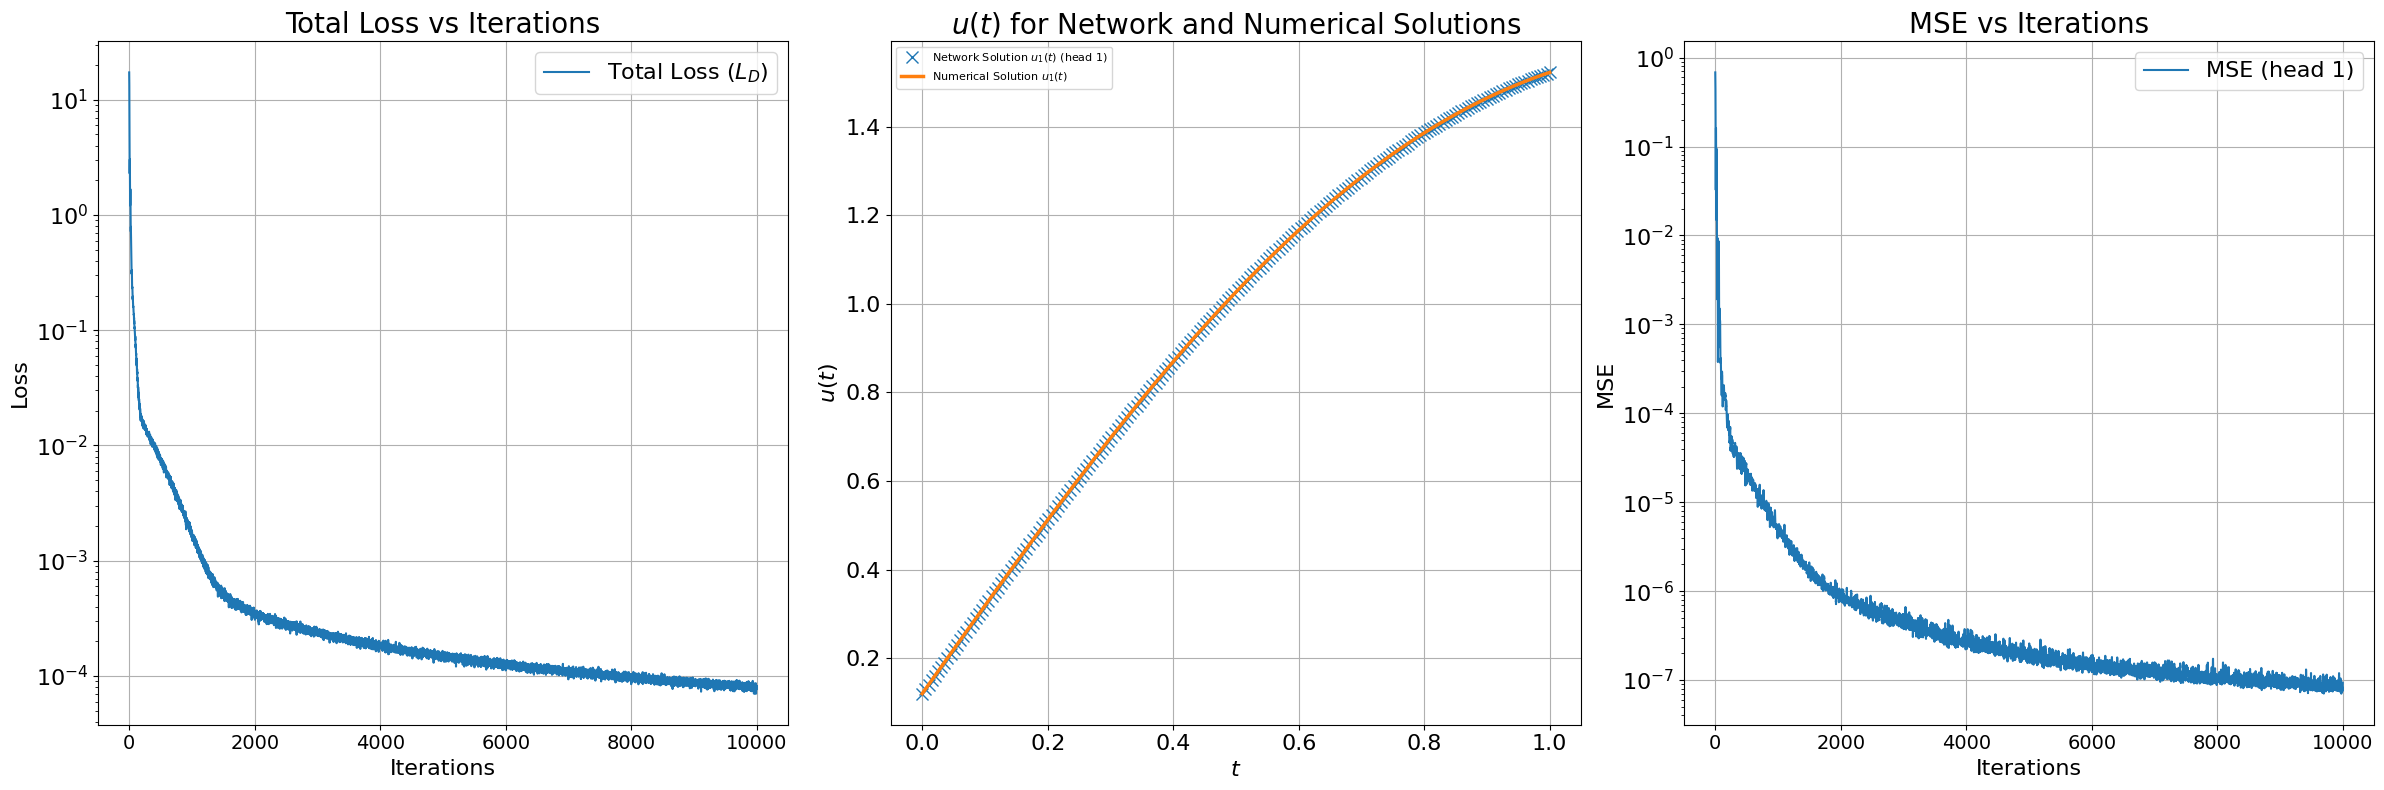

In [14]:
# plot the total loss, network vs true solution and MSE for two non-coupled equations
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_funct, iterations=iterations, 
                           trained_model=trained_model, v_list=v_list, A_list=A_list, 
                           force=force, train_losses=loss_hist['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_hist, 
                           head_to_track=head_to_track, is_A_time_dep=is_A_time_dep)

### Step 4a: Recover Weights for a Set of Training Parameters

Time to compute H and dH_dt:  0.068 seconds
Time to compute weights (given H and dH_dt):  1.145 seconds


<ipython-input-10-ead37a41ff05>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)


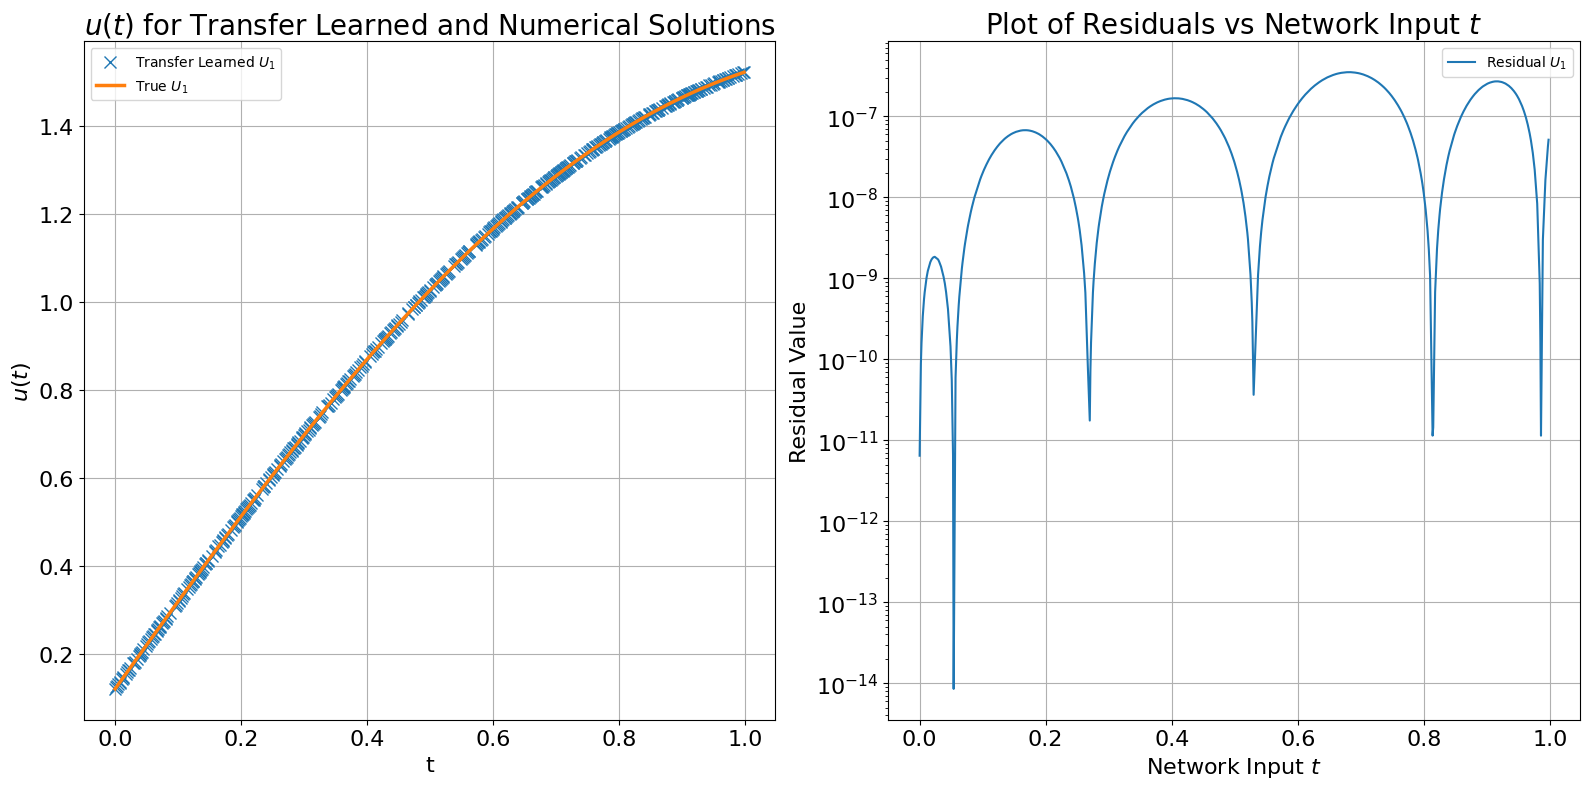

In [15]:
# forward pass to extract H
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay)

# choose an initial condition and set of coefficients that were trained on
v = v_list[0]
A = A_list[0]
M_inv, W_out, force_terms = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                         v, A, force, is_A_time_dep, 
                                                         num_equations)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force, 
                                     num_equations, true_funct, is_A_time_dep)

### Step 4b: Perform One-Shot Transfer Learning - New Initial Condition

<ipython-input-10-ead37a41ff05>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)


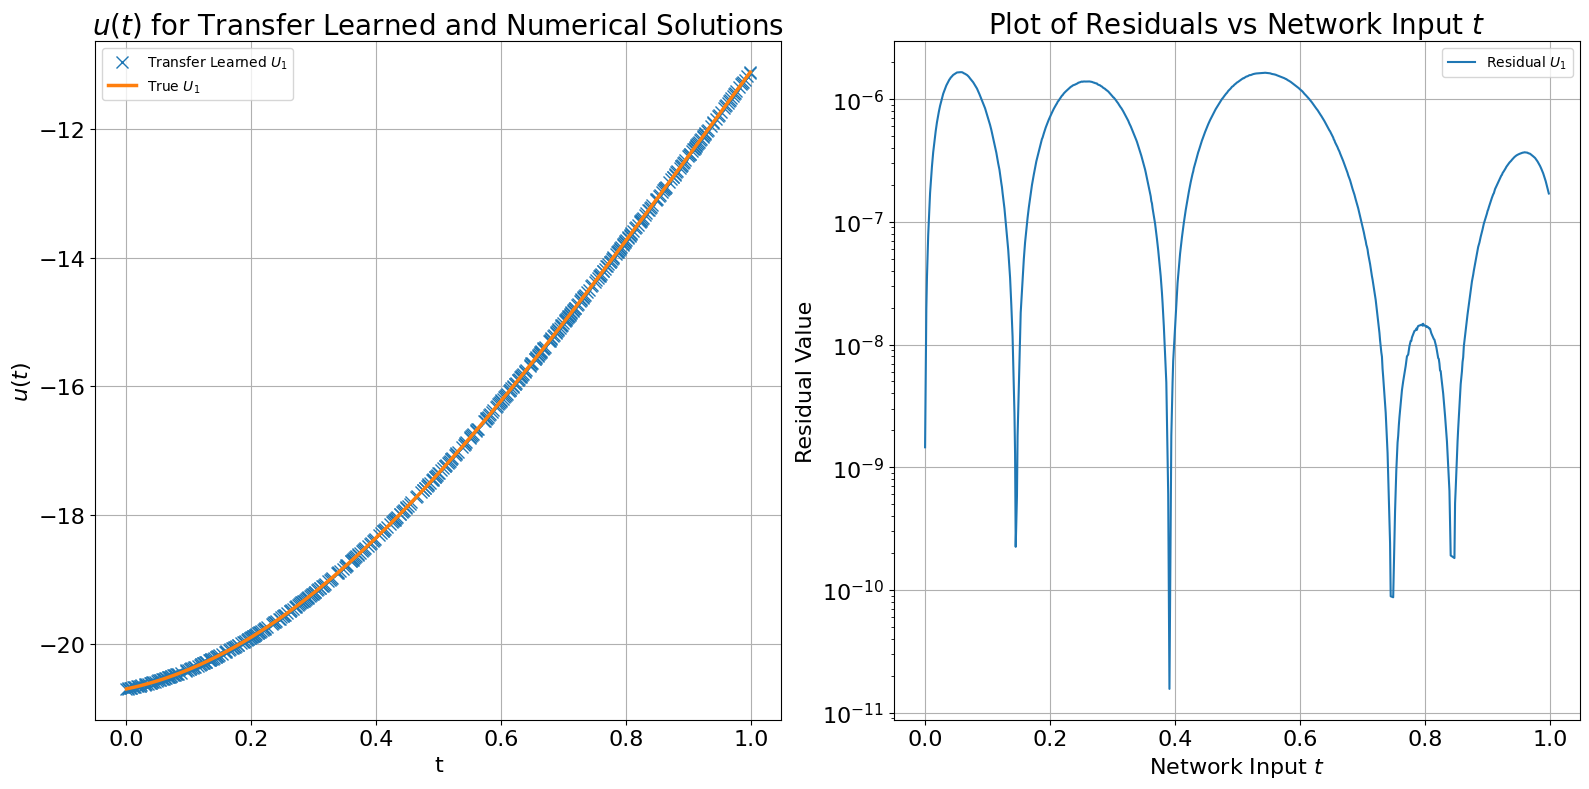

In [16]:
# choose a new initial condition
v_transfer = torch.tensor([[-20.69]], device=dev)

# compute the transfer learned solution
W_out_transfer = torch.matmul(M_inv, force_terms + torch.matmul(H_0.T, v_transfer))

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_transfer, t_eval, v_transfer, A, force, 
                                     num_equations, true_funct, is_A_time_dep)

### Step 4c: Perform One-Shot Transfer Learning - New Equation Coefficients

Time to compute weights (given H and dH_dt):  0.012 seconds


<ipython-input-10-ead37a41ff05>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)


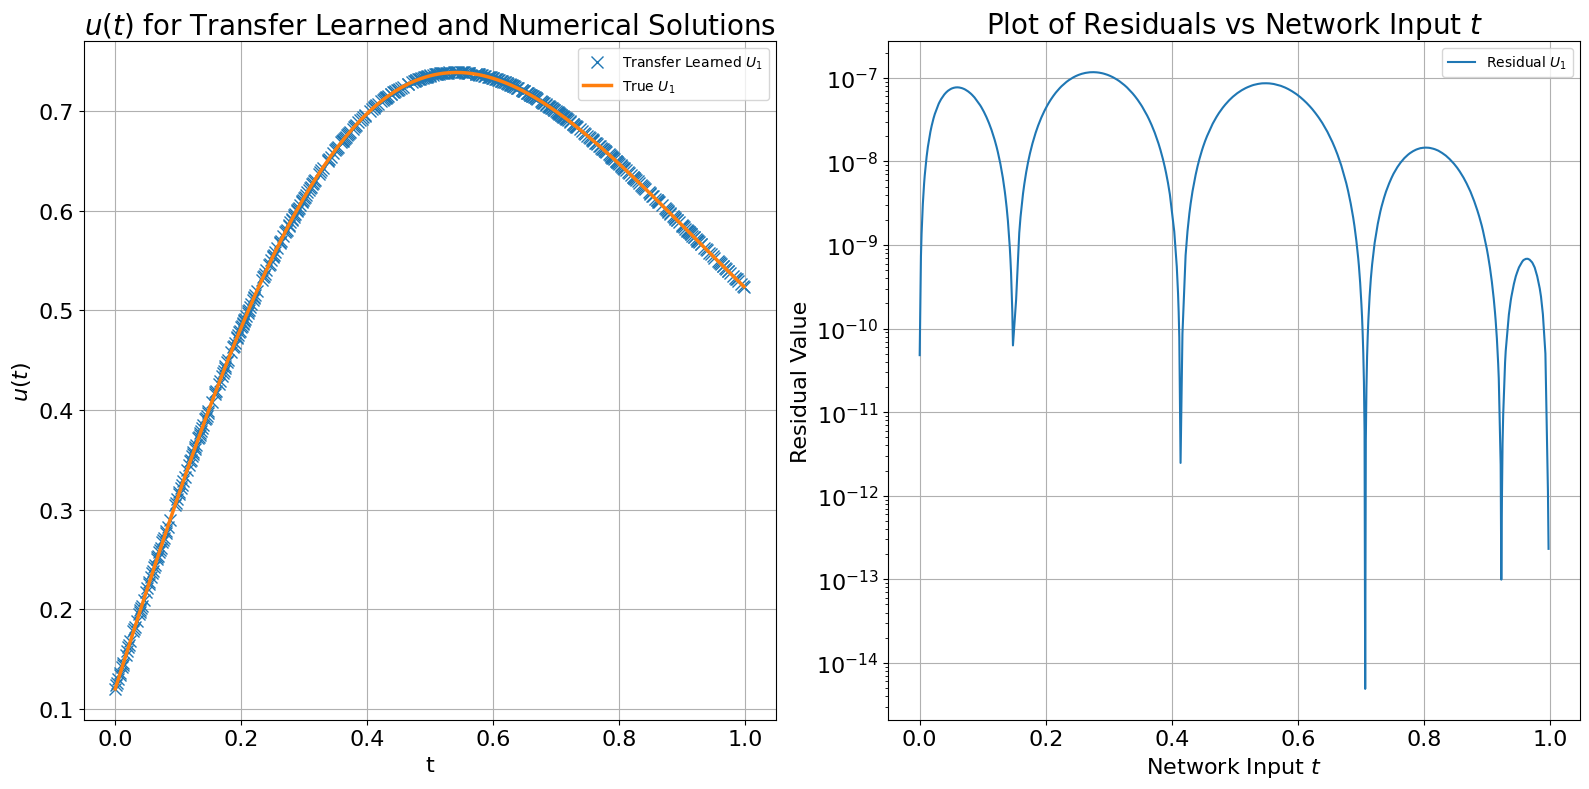

In [17]:
# choose a new set of equation coefficients
transfer_A = lambda t: 5.0 * t

# compute the transfer learned solution
M_inv_new, W_out_new_A, force_terms_new = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                                       v, transfer_A, force, is_A_time_dep, 
                                                                       num_equations)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, v, transfer_A, force, 
                                     num_equations, true_funct, is_A_time_dep)

### Step 4d: Perform One-Shot Transfer Learning - New Initial Condition and Equation Coefficients

Time to compute weights (given H and dH_dt):  0.011 seconds


<ipython-input-10-ead37a41ff05>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)


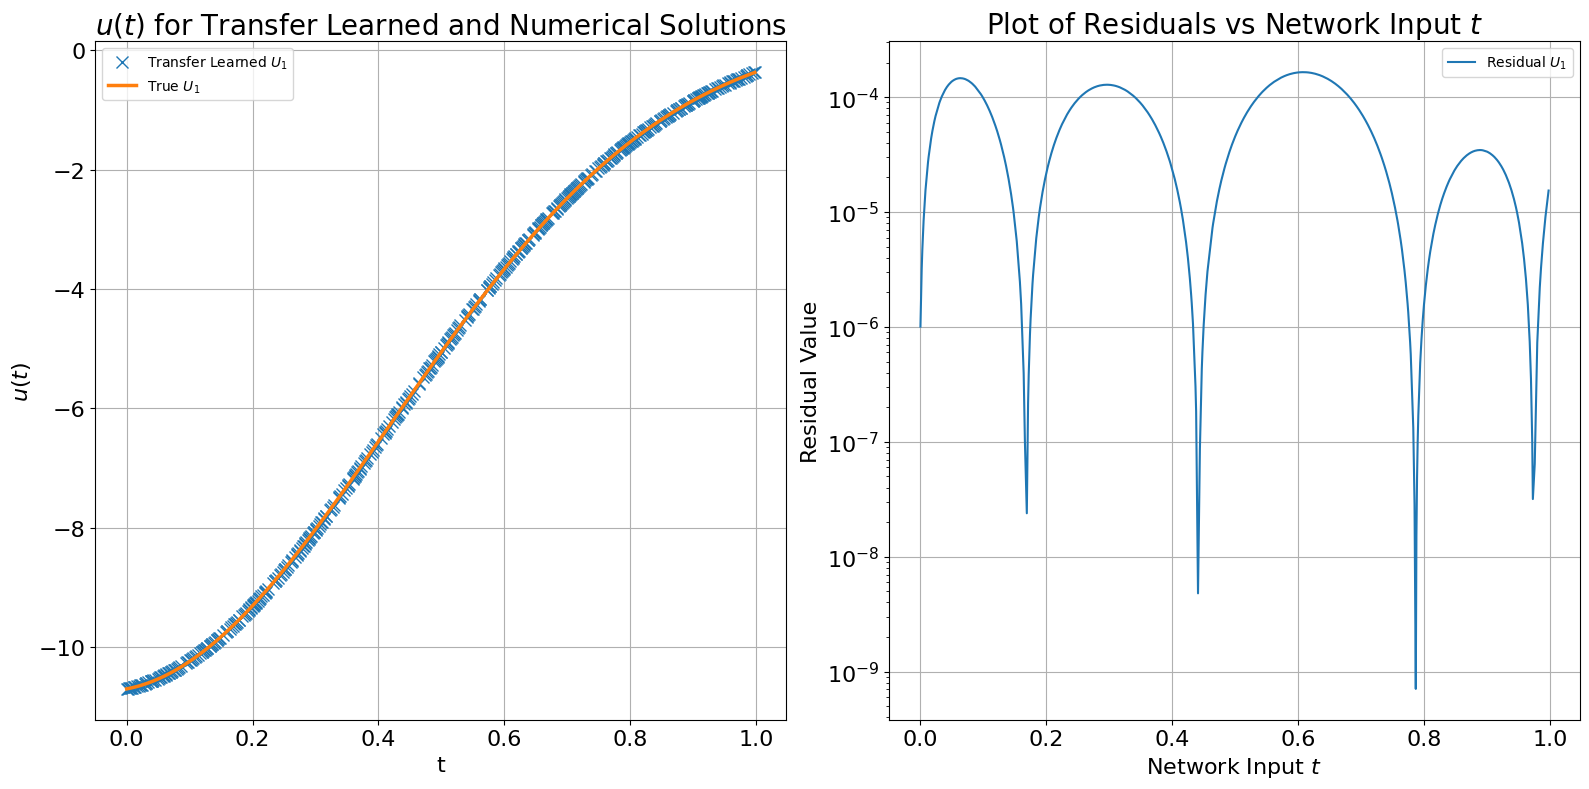

In [18]:
# change both initial condition and differential equation coefficients
v_transfer_new = torch.tensor([[-10.70]], device=dev)
transfer_A = lambda t: 5.0 * t

# compute the transfer learned solution
M_inv_new_all, W_out_new_A_all, force_terms_new_all = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                                           v_transfer_new, transfer_A, force,
                                                                           is_A_time_dep, num_equations)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A_all, t_eval, v_transfer_new, transfer_A, 
                                     force, num_equations, true_funct, is_A_time_dep)

### Step 4e: Perform One-Shot Transfer Learning - New Forcing Function

Time to compute weights (given H and dH_dt):  0.011 seconds


<ipython-input-10-ead37a41ff05>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
<ipython-input-10-ead37a41ff05>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)


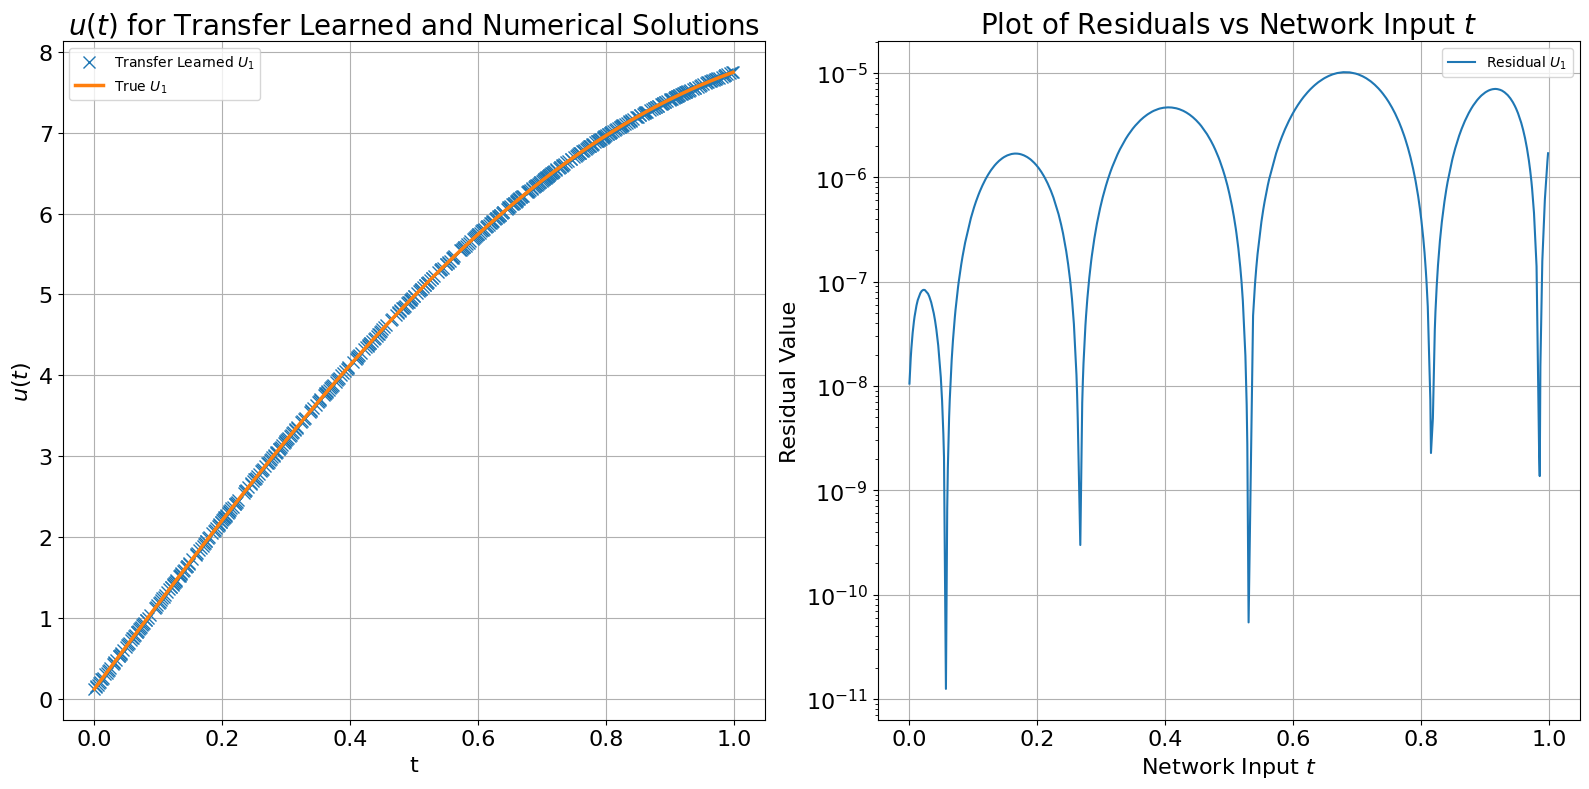

In [19]:
# change the forcing function
force_test = torch.tensor([[10.6]], device=dev)

# compute the transfer learned solution
M_inv_newF, W_out_newF, force_terms_newF = analytically_compute_weights(dH_dt_new, H, H_0, t_eval, 
                                                                       v, A, force_test,
                                                                       is_A_time_dep, num_equations)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_newF, t_eval, v, A, force_test, 
                                     num_equations, true_funct, is_A_time_dep)

# Efficiency Analysis Code - Non-time Dependent Coefficients (Thesis Only)

### Time One-Shot Transfer Learning Approach

In [20]:
# function to calculate the time needed to compute many solutions for One-Shot T.L. approach when changing intial conditions
def one_shot_time_u0_change(dH_dt, H, H_0, t_eval, v_sample, A, force, 
                                 is_A_time_dep, num_equations, num_calls):
    
    # timer for computing one-shot approach and changing u0
    start_time = time.time()
    
    # compute dH_dt * dH_dt.T
    dH_dt_times_dH_dt_T = torch.matmul(dH_dt.mT, dH_dt)

    # compute dH_dt * A * H, H.T * A.T * dH_dt, and  H.T * A.T * A * H
    if not is_A_time_dep:
      dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A), H)
      H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A.T), dH_dt)
      H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A.T), A), H)
    else:
      dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A(t_eval).reshape(-1, num_equations, 1)), H)
      H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A(t_eval).T.reshape(-1, num_equations, 1)), dH_dt)
      H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A(t_eval).T.reshape(-1, num_equations, 1)), A(t_eval).reshape(-1, num_equations, 1)), H)
    
    # compute the "summation portion" of the M matrix 
    M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
    M_sum_terms = M_sum_terms.sum(axis=0)
    M_sum_terms = M_sum_terms / len(t_eval)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)
    
    # compute the "M" matrix and invert it
    M = M_sum_terms + H_0_T_times_H_0
    M_inv = torch.linalg.pinv(M)
    
    # compute dH_dt * force
    dH_dt_times_force = torch.matmul(dH_dt.mT, force)
    
    # compute H * A.T * force
    if not is_A_time_dep:
      H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A.T), force)
    else:
      H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A(t_eval).T.reshape(-1, num_equations, 1)), force)
    
    # sum the force-contributing terms and add them to H_0.T * v
    force_terms = dH_dt_times_force + H_times_A_T_times_f
    force_terms = force_terms.sum(axis=0)
    force_terms = force_terms / len(t_eval)

    # perform num_calls changes of u0
    for i in range(num_calls):
      v_rand = torch.randn_like(v_sample, device=dev)
      rhs_terms = force_terms + torch.matmul(H_0.T, v_rand)
      # compute the output weights by W_out = M ^ -1 * H_0 * u_0
      W_out = torch.matmul(M_inv, rhs_terms)

    # end the timer for computing one-shot approach and changing u0
    end_time = time.time()
    total_time = end_time - start_time

    print(f"Time to do one-shot for {num_calls} u0 changes: {total_time: .3f} seconds")

In [21]:
# function to calculate the time needed to compute many solutions for One-Shot T.L. approach when changing equation coefficients
def one_shot_time_A_change(dH_dt, H, H_0, t_eval, v, A_sample, force, 
                                 is_A_time_dep, num_equations, num_calls):
    
    # timer for computing one-shot approach and changing A
    start_time = time.time()
    
    # compute dH_dt * dH_dt.T
    dH_dt_times_dH_dt_T = torch.matmul(dH_dt.mT, dH_dt)

    # compute H_0.T * H_0
    H_0_T_times_H_0 = torch.matmul(H_0.mT, H_0)

    # compute dH_dt * force
    dH_dt_times_force = torch.matmul(dH_dt.mT, force)

    # compute H_0 * u_0
    H_0_times_u_0 = torch.matmul(H_0.T, v)

    # compute M num_calls times
    for i in range(num_calls):

      A_rand = torch.randn_like(A_sample, device=dev)

      # compute dH_dt * A * H,  H.T * A.T * dH_dt, H.T * A.T * A * H, and  H * A.T * force
      if not is_A_time_dep:
        dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A_rand), H)
        H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A_rand.T), dH_dt)
        H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A_rand.T), A_rand), H)
        H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A_rand.T), force)
      else:
        dH_dt_times_A_times_H = torch.matmul(torch.matmul(dH_dt.mT, A_rand(t_eval).reshape(-1, num_equations, 1)), H)
        H_times_A_T_times_dH_dt = torch.matmul(torch.matmul(H.mT, A_rand(t_eval).T.reshape(-1, num_equations, 1)), dH_dt)
        H_T_times_A_T_times_A_times_H = torch.matmul(torch.matmul(torch.matmul(H.mT, A_rand(t_eval).T.reshape(-1, num_equations, 1)), A_rand(t_eval).reshape(-1, num_equations, 1)), H)
        H_times_A_T_times_f = torch.matmul(torch.matmul(H.mT, A_rand(t_eval).T.reshape(-1, num_equations, 1)), force)
    
      # compute the "summation portion" of the M matrix 
      M_sum_terms = dH_dt_times_dH_dt_T + dH_dt_times_A_times_H + H_times_A_T_times_dH_dt + H_T_times_A_T_times_A_times_H
      M_sum_terms = M_sum_terms.sum(axis=0)
      M_sum_terms = M_sum_terms / len(t_eval)
      
      # compute the "M" matrix and invert it
      M = M_sum_terms + H_0_T_times_H_0
      M_inv = torch.linalg.pinv(M)
  
      # sum the force-contributing terms and add them to H_0.T * v
      force_terms = dH_dt_times_force + H_times_A_T_times_f
      force_terms = force_terms.sum(axis=0)
      force_terms = force_terms / len(t_eval)
      rhs_terms = force_terms + H_0_times_u_0

      # compute the output weights by W_out = M ^ -1 * H_0 * u_0
      W_out = torch.matmul(M_inv, rhs_terms)

    # end the timer for computing one-shot approach and changing A
    end_time = time.time()
    total_time = end_time - start_time

    print(f"Time to do one-shot for {num_calls} A changes: {total_time: .3f} seconds")

### Time Runge Kutta Approach

In [22]:
# function to calculate the time needed to compute many solutions for Runge-Kutta approach when changing intial conditions
def runge_kutta_time_u0_change(x_range, true_funct, v_sample, A, force, is_A_time_dep, num_calls):

  # x values to predict on
  min_x, max_x = x_range
  xx = np.linspace(min_x, max_x, 200)[:, None]
  
  # store the true solutions
  yts = []

  # start the timer for runge-kutta
  start_time = time.time()

  # perform num_calls changes of u0
  for i in range(num_calls):
    with torch.no_grad():

      # v_rand = torch.randn_like(v_sample, device=dev)
      v_rand = v
      # find the true solution if A is not time independent
      if not is_A_time_dep:
        yts.append(true_funct(xx, v_rand.detach().cpu(), A.detach().cpu(), 
                                force.detach().detach().cpu()))
      # find the true solution if A is time dependent
      else:
        yts.append(true_funct(xx, v_rand.detach().cpu(), A, 
                                force.detach().detach().cpu()))

  # end the timer for runge-kutta 
  end_time = time.time()
  total_time = end_time - start_time

  print(f"Time to do Runge-Kutta for {num_calls} u0 changes: {total_time: .3f} seconds")


In [23]:
# function to calculate the time needed to compute many solutions for Runge Kutta approach when changing equation coefficients 
def runge_kutta_time_A_change(x_range, true_funct, v, A_sample, force, is_A_time_dep, num_calls):

  # x values to predict on
  min_x, max_x = x_range
  xx = np.linspace(min_x, max_x, 200)[:, None]
  
  # store the true solutions
  yts = []

  # start the timer for runge-kutta
  start_time = time.time()

  # perform num_calls changes of A
  for i in range(num_calls):
    with torch.no_grad():

      # A_rand = torch.randn_like(A_sample, device=dev)
      A_rand = A
      # find the true solution if A is not time independent
      if not is_A_time_dep:
        yts.append(true_funct(xx, v.detach().cpu(), A_rand.detach().cpu(), 
                                force.detach().detach().cpu()))
      # find the true solution if A is time dependent
      else:
        yts.append(true_funct(xx, v.detach().cpu(), A_rand, 
                                force.detach().detach().cpu()))

  # end the timer for runge-kutta 
  end_time = time.time()
  total_time = end_time - start_time

  print(f"Time to do Runge-Kutta for {num_calls} A changes: {total_time: .3f} seconds")

### Run Both Approaches

In [ ]:
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay)

# pick an initial condition and matrix from those that were trained on (easy case)
v = v_list[0]
A = A_list[0]
one_shot_time_u0_change(dH_dt_new, H, H_0, t_eval, v, A, force, is_A_time_dep, num_equations, 1000)
runge_kutta_time_u0_change(x_range, true_funct, v, A, force, is_A_time_dep, 1000)

Time to compute H and dH_dt:  0.095 seconds
Time to do one-shot for 1000 u0 changes:  0.075 seconds
Time to do Runge-Kutta for 1000 u0 changes:  6.034 seconds


In [24]:
one_shot_time_A_change(dH_dt_new, H, H_0, t_eval, v, A, force, is_A_time_dep, num_equations, 1000)
runge_kutta_time_A_change(x_range, true_funct, v, A, force, is_A_time_dep, 1000)